In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
import MeshCat as mc 
using JLD2
using Test
using Random
include(joinpath(@__DIR__,"utils/cartpole_animation.jl"))
include(joinpath(@__DIR__,"utils/basin_of_attraction.jl"))


  Activating project at `c:\MyWork\Course\OptimalControl_RL\HW\HW2_S25-main`


plot_basin_of_attraction (generic function with 1 method)

## Note: 

Some of the cells below will have multiple outputs (plots and animations), it can be easier to see everything if you do `Cell -> All Output -> Toggle Scrolling`, so that it simply expands the output area to match the size of the outputs.

# Q2: LQR for nonlinear systems (40 pts)

## Linearization warmup 
Before we apply LQR to nonlinear systems, we are going to treat our linear system as if it's nonlinear. Specifically, we are going to "approximate" our linear system with a first-order Taylor series, and define a new set of $(\Delta x, \Delta u)$ coordinates. Since our dynamics are linear, this approximation is exact, allowing us to check that we set up the problem correctly. 

First, assume our discrete time dynamics are the following:

$$ x_{k+1} = f(x_k,u_k) $$

And we are going to linearize about a reference trajectory $\bar{x}_{1:N}, \bar{u}_{1:N-1}$. From here, we can define our delta's accordingly:

$$ \begin{align} x_k &= \bar{x}_k + \Delta x_k \\ u_k &= \bar{u}_k + \Delta u_k \end{align}$$  

Next, we are going to approximate our discrete time dynamics function with the following first order Taylor series:

$$ 
x_{k+1} \approx f(\bar{x}_k, \bar{u}_k) + \bigg[\frac{\partial f}{\partial x} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg](x_k - \bar{x}_k) + \bigg[\frac{\partial f}{\partial u} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg](u_k - \bar{u}_k)
$$

Which we can substitute in our delta notation to get the following:

$$ 
\bar{x}_{k+1} + \Delta x_{k+1} \approx f(\bar{x}_k, \bar{u}_k) + \bigg[\frac{\partial f}{\partial x} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg]\Delta x_k + \bigg[\frac{\partial f}{\partial u} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg] \Delta u_k
$$

If the trajectory $\bar{x},\bar{u}$ is dynamically feasible (meaning $\bar{x}_{k+1} = f(\bar{x}_k, \bar{u}_k)$), then we can cancel these equivalent terms on each side of the above equation, resulting in the following:

$$ 
 \Delta x_{k+1} \approx  \bigg[\frac{\partial f}{\partial x} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg]\Delta x_k + \bigg[\frac{\partial f}{\partial u} \bigg|_{\bar{x}_k, \bar{u}_k}  \bigg] \Delta u_k
$$

## Cartpole 
We are now going to look at two different applications of LQR to the nonlinear cartpole system. Given the following description of the cartpole:
<div>
<img src="cartpole.png" width="300"/>
</div>
(if this image doesn't show up, check out `cartpole.png`)


with a cart position $p$ and pole angle $\theta$. We are first going to linearize the nonlinear discrete dynamics of this system about the point where $p = 0$, and $\theta = 0$ (no velocities), and use an infinite horizon LQR controller about this linearized state to stabilize the cartpole about this goal state.  The dynamics of the cartpole are parametrized by the mass of the cart, the mass of the pole, and the length of the pole. To simulate a "sim to real gap", we are going to design our controllers around an estimated set of problem parameters `params_est`, and simulate our system with a different set of problem parameters `params_real`. 

In [2]:
"""
continuous time dynamics for a cartpole, the state is 
x = [p, θ, ṗ, θ̇]
where p is the horizontal position, and θ is the angle
where θ = 0 has the pole hanging down, and θ = 180 is up.

The cartpole is parametrized by a cart mass `mc`, pole 
mass `mp`, and pole length `l`. These parameters are loaded 
into a `params::NamedTuple`. We are going to design the
controller for a estimated `params_est`, and simulate with 
`params_real`. 
"""
function dynamics(params::NamedTuple, x::Vector, u)
    # cartpole ODE, parametrized by params. 

    # cartpole physical parameters 
    mc, mp, l = params.mc, params.mp, params.l
    g = 9.81
    
    q = x[1:2]
    qd = x[3:4]

    s = sin(q[2])
    c = cos(q[2])

    H = [mc+mp mp*l*c; mp*l*c mp*l^2]
    C = [0 -mp*qd[2]*l*s; 0 0]
    G = [0, mp*g*l*s]
    B = [1, 0]

    qdd = -H\(C*qd + G - B*u[1])
    return [qd;qdd]

end

# true nonlinear dynamics of the system
# if I want to simulate, this is what I do
function rk4(params::NamedTuple, x::Vector,u,dt::Float64)
    # vanilla RK4
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + k1/2, u)
    k3 = dt*dynamics(params, x + k2/2, u)
    k4 = dt*dynamics(params, x + k3, u)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

rk4 (generic function with 1 method)

## Part A: Infinite Horizon LQR about an equilibrium (10 pts)
Here we are going to solve for the infinite horizon LQR gain, and use it to stabilize the cartpole about the unstable equilibrium. 

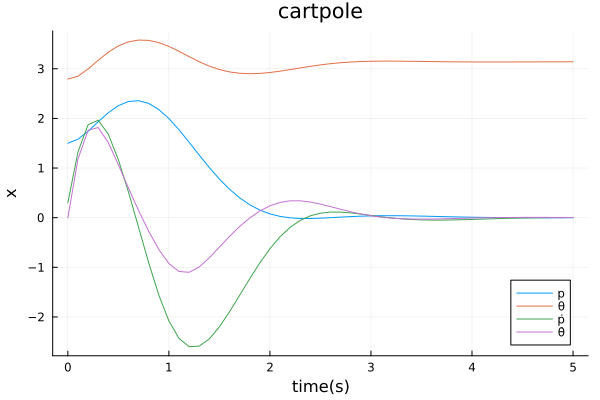

┌ Info: Listening on: 127.0.0.1:8700, thread id: 1
└ @ HTTP.Servers C:\Users\Admin\.julia\packages\HTTP\4AUPl\src\Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\Admin\.julia\packages\MeshCat\9QrxD\src\visualizer.jl:43


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "b" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x62], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x63, 0x61, 0x72, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "a" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x61], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8700, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8700), "127.0.0.1", "8700", nothing, Sockets.TCPServer(Base.Libc.WindowsRawSocket(0x000000000000222c) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x00000159473b43f0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 1483495775984, 1483496070832))), MeshCat.AnimationContext[]))

Test Summary: | Pass  Total   Time
LQR about eq  |    3      3  15.6s


Test.DefaultTestSet("LQR about eq", Any[], 3, false, false, true, 1.739200770779e9, 1.739200786429e9, false, "c:\\MyWork\\Course\\OptimalControl_RL\\HW\\HW2_S25-main\\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl")

In [3]:
@testset "LQR about eq" begin
    
    # states and control sizes 
    nx = 4 
    nu = 1 
    
    # desired x and g (linearize about these)
    xgoal = [0, pi, 0, 0]
    ugoal = [0]
    
    # initial condition (slightly off of our linearization point)
    x0 = [0, pi, 0, 0] + [1.5, deg2rad(-20), .3, 0]
    
    # simulation size 
    dt = 0.1 
    tf = 5.0 
    t_vec = 0:dt:tf
    N = length(t_vec)
    X = [zeros(nx) for i = 1:N]
    X[1] = x0 
    
    # estimated parameters (design our controller with these)
    params_est = (mc = 1.0, mp = 0.2, l = 0.5)
    
    # real paremeters (simulate our system with these)
    params_real = (mc = 1.2, mp = 0.16, l = 0.55)
    
    # TODO: solve for the infinite horizon LQR gain Kinf
    A = FD.jacobian(_x->rk4(params_est, _x, ugoal, dt), xgoal)
    B = FD.jacobian(_u->rk4(params_est, xgoal, _u, dt), ugoal)
    
    # cost terms 
    Q = diagm([1,1,.05,.1])
    R = 0.1*diagm(ones(nu))
    
    Kinf = zeros(1,4)
    P = deepcopy(Q)

    for i = (N-1):-1:1
        K = (R + B'*P*B)\(B'*P*A)
        _P = deepcopy(P)
        P = Q + A'*P*(A-B*K)
        if (norm(_P - P) <= 1e-3)
            Kinf = K
            break
        end
        if i==1
            Kinf = K
        end
    end
    
    # TODO: simulate this controlled system with rk4(params_real, ...)
    for k=1:(N-1)
        u_lqr = ugoal .- Kinf*(X[k] - xgoal)
        X[k+1]= rk4(params_real, X[k], u_lqr, dt)
    end

    
    # ---------------tests and plots/animations---------------
    @test X[1] == x0 
    @test norm(X[end])>0
    @test norm(X[end] - xgoal) < 0.1 
    
    Xm = hcat(X...)
    display(plot(t_vec,Xm',title = "cartpole",
                 xlabel = "time(s)", ylabel = "x",
                 label = ["p" "θ" "ṗ" "θ̇"]))
    
    # animation stuff
    display(animate_cartpole(X, dt))
    # ---------------tests and plots/animations---------------
end

## Part B: Infinite horizon LQR basin of attraction (5 pts)

In part A we built a controller for the cartpole that was based on a linearized version of the system dynamics. This linearization took place at the `(xgoal, ugoal)`, so we should only really expect this model to be accurate if we are close to this linearization point (think small angle approximation). As we get further from the goal state, our linearized model is less and less accurate, making the performance of our controller suffer. At a certain point, the controller is unable to stabilize the cartpole due to this model mismatch. 

To demonstrate this, you are now being asked to take the same controller you used above, and try it for a range of initial conditions. For each of these simulations, you will determine if the controller was able to stabilize the cartpole. From here, you will plot the successes and failures on a plot and visualize a "basin of attraction", that is, a region of the state space where we expect our controller to stabilize the system. 

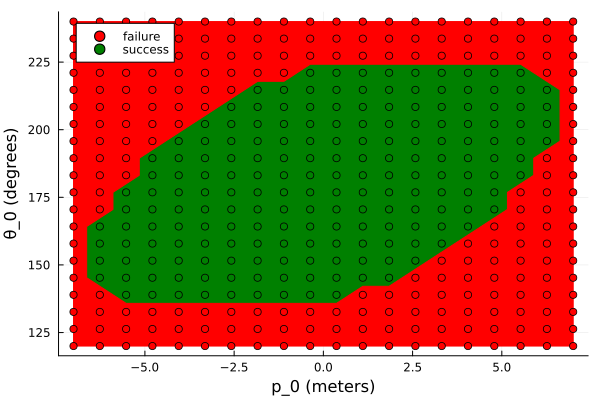

Test Passed

In [8]:
function create_initial_conditions()
    # create a span of initial configurations 
    M=20
    ps = LinRange(-7, 7, M)
    thetas = LinRange(deg2rad(180-60), deg2rad(180+60), M)
    
    initial_conditions = []
    
    for p in ps 
        for theta in thetas 
            push!(initial_conditions, [p, theta, 0, 0.0])
        end
    end
    
    return initial_conditions, ps, thetas
end

function check_simulation_convergence(params_real, initial_condition, Kinf, xgoal, N, dt)
    """
    args
        params_real: named tuple with model dynamics parametesr 
        initial_condition: X0, length 4 vector 
        Kinf: IHLQR feedback gain 
        xgoal: desired state, length 4 vector 
        N: number of simulation steps
        dt: time between steps 
    
    return
        is_controlled: bool 
    """

    x0= 1 * initial_condition 

    is_controlled = false
    
    # TODO: simulate the closed-loop (controlled) cartpole starting at the initial condition 
    
    # for some of the unstable initial conditions, the integrator will "blow up", in order to 
    # catch these errors, you can stop the sim and return is_controlled = false if norm(x) > 100 
    
    # you should consider the simulation to have been successfuly controlled if the 
    # L2 norm of |xfinal - xgoal| < 0.1. (norm(xfinal-xgoal) < 0.1 in Julia)
    X = [zeros(size(x0)) for i = 1:N]
    X[1] = 1*x0 

    for k=1:(N-1)
        u_lqr = - Kinf*(X[k] - xgoal)
        X[k+1]= rk4(params_real, X[k], u_lqr, dt)
        if norm(X[k+1]) > 100
            is_controlled = false
            return is_controlled
        end
    end
    
    if norm(X[N]-xgoal)<0.1
        is_controlled = true
    end

    return is_controlled 
end

let 
    
    nx = 4 
    nu = 1 
    xgoal = [0, pi, 0, 0]
    ugoal = [0]
    dt = 0.1 
    tf = 5.0 
    t_vec = 0:dt:tf
    N = length(t_vec)
    
    
    # estimated parameters (design our controller with these)
    params_est = (mc = 1.0, mp = 0.2, l = 0.5)
    
    # real paremeters (simulate our system with these)
    params_real = (mc = 1.2, mp = 0.16, l = 0.55)
    
    # TODO: solve for the infinite horizon LQR gain Kinf
    # this is the same controller as part B
    A = FD.jacobian(_x->rk4(params_est, _x, ugoal, dt), xgoal)
    B = FD.jacobian(_u->rk4(params_est, xgoal, _u, dt), ugoal)
    
    # cost terms 
    Q = diagm([1,1,.05,.1])
    R = 0.1*diagm(ones(nu))
    
    Kinf = zeros(1,4)
    P = deepcopy(Q)

    for i = (N-1):-1:1
        K = (R + B'*P*B)\(B'*P*A)
        _P = deepcopy(P)
        P = Q + A'*P*(A-B*K)
        if (norm(_P - P) <= 1e-3)
            Kinf = K
            break
        end
        if i==1
            Kinf = K
        end
    end
    
    # create the set of initial conditions we want to test for convergence
    initial_conditions, ps, thetas = create_initial_conditions()
    
    convergence_list = [] 
    
    for initial_condition in initial_conditions

        convergence = check_simulation_convergence(params_real,
                                                   initial_condition,
                                                   Kinf, xgoal, N, dt)
        
        push!(convergence_list, convergence)
    end
    
    plot_basin_of_attraction(initial_conditions, convergence_list, ps, rad2deg.(thetas))
    

    # -------------tests------------------
    @test sum(convergence_list) < 190 
    @test sum(convergence_list) > 180 
    @test length(convergence_list) == 400 
    @test length(initial_conditions) == 400
        
end

## Part C: Infinite horizon LQR cost tuning (5 pts)

We are now going to tune the LQR cost to satisfy our following performance requirement:

$\|x(5.0) - x_{\text{goal}}\|_2=$`norm(X[N] - xgoal) < 0.1` 

which says that the L2 norm of the state at 5 seconds (last timestep in our simulation) should be less than 0.1. We are also going to have to deal with the following actuator limits: $-3 \leq u \leq 3$. You won't be able to directly reason about this actuator limit in our LQR controller, but we can tune our cost function to avoid saturating the actuators (reaching the actuator limits) for too long. Here are our suggestions for tuning successfully:

1. First, adjust the values in Q and R to find a controller that stabilizes the cartpole. The key here is tuning our cost to keep the control away from the actuator limits for too long. 
2. Now that you can stabilize the system, the next step is to tune the values in Q and R accomplish our performance goal of `norm(X[N] - xgoal) < 0.1`. Think about the individual values in Q, and which states we really want to penalize. The positions $(p,\, \theta)$ should be penalized differently than the velocities $(\dot{p}, \,\dot{\theta})$. 

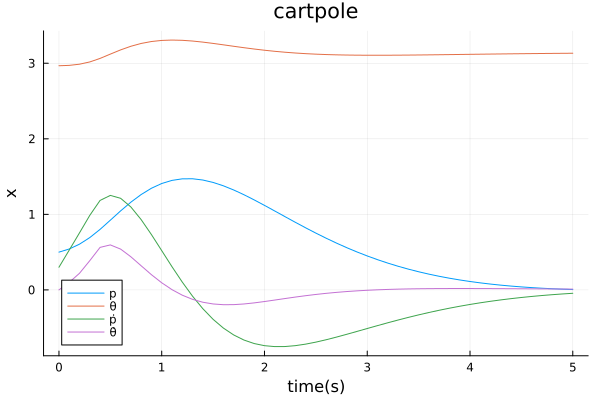

┌ Info: Listening on: 127.0.0.1:8701, thread id: 1
└ @ HTTP.Servers C:\Users\Admin\.julia\packages\HTTP\4AUPl\src\Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8701
└ @ MeshCat C:\Users\Admin\.julia\packages\MeshCat\9QrxD\src\visualizer.jl:43


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "b" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x62], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x63, 0x61, 0x72, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "a" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x61], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8701, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8701), "127.0.0.1", "8701", nothing, Sockets.TCPServer(Base.Libc.WindowsRawSocket(0x00000000000023c4) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x000001594a3709c0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 142388972757))), MeshCat.AnimationContext[]))

Test Summary: | Pass  Total   Time
LQR about eq  |    4      4  10.6s


Test.DefaultTestSet("LQR about eq", Any[], 4, false, false, true, 1.739202097181e9, 1.739202107753e9, false, "c:\\MyWork\\Course\\OptimalControl_RL\\HW\\HW2_S25-main\\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl")

In [9]:
@testset "LQR about eq" begin
    
    # states and control sizes 
    nx = 4 
    nu = 1 
    
    # desired x and g (linearize about these)
    xgoal = [0, pi, 0, 0]
    ugoal = [0]
    
    # initial condition (slightly off of our linearization point)
    x0 = [0, pi, 0, 0] + [0.5, deg2rad(-10), .3, 0]
    
    # simulation size 
    dt = 0.1 
    tf = 5.0 
    t_vec = 0:dt:tf
    N = length(t_vec)
    X = [zeros(nx) for i = 1:N]
    X[1] = x0 
    
    # estimated parameters (design our controller with these)
    params_est = (mc = 1.0, mp = 0.2, l = 0.5)
    
    # real paremeters (simulate our system with these)
    params_real = (mc = 1.2, mp = 0.16, l = 0.55)
    
    # TODO: solve for the infinite horizon LQR gain Kinf
    
    # cost terms
    Q = diagm([1,1,.01,.01])
    R = 1*diagm(ones(nu))

    Kinf = zeros(1,4)
    A = FD.jacobian(_x->rk4(params_est, _x, ugoal, dt), xgoal)
    B = FD.jacobian(_u->rk4(params_est, xgoal, _u, dt), ugoal)
    P = deepcopy(Q)

    for i = (N-1):-1:1
        K = (R + B'*P*B)\(B'*P*A)
        _P = deepcopy(P)
        P = Q + A'*P*(A-B*K)
        if (norm(_P - P) <= 1e-3)
            Kinf = K
            break
        end
        if i==1
            Kinf = K
        end
    end
    
    # vector of length 1 vectors for our control
    U = [[0.0] for i = 1:N-1]
    
    # TODO: simulate this controlled system with rk4(params_real, ...)
    # TODO: make sure you clamp the control input with clamp.(U[i], -3.0, 3.0)
    for k=1:(N-1)
        U[k] = clamp.(ugoal - Kinf*(X[k] - xgoal), -3.0, 3.0)
        X[k+1] = rk4(params_real, X[k], U[k], dt)
    end
  
      
    
    # ---------------tests and plots/animations---------------
    @test X[1] == x0  # initial condition is used
    @test norm(X[end])>0 # end is nonzero
    @test norm(X[end] - xgoal) < 0.1 # within 0.1 of the goal 
    @test norm(vcat(U...), Inf) <= 3.0 # actuator limits are respected
    
    Xm = hcat(X...)
    display(plot(t_vec,Xm',title = "cartpole",
                 xlabel = "time(s)", ylabel = "x",
                 label = ["p" "θ" "ṗ" "θ̇"]))
    
    # animation stuff
    display(animate_cartpole(X, dt))
    # ---------------tests and plots/animations---------------
    
    
end

## Part D: TVLQR for trajectory tracking (15 pts)

Here we are given a swingup trajectory that works for `params_est`, but will fail to work with `params_real`. To account for this sim to real gap, we are going to track this trajectory with a TVLQR controller. 

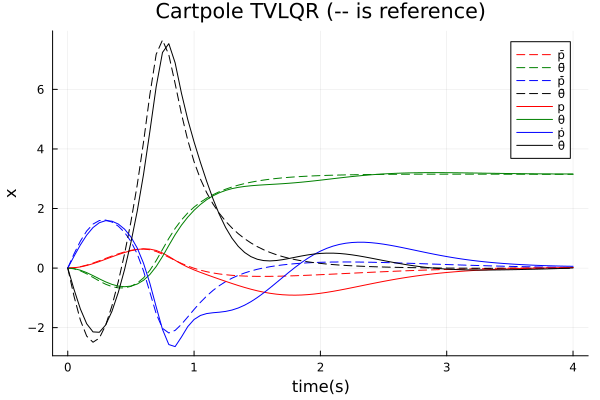

┌ Info: Listening on: 127.0.0.1:8702, thread id: 1
└ @ HTTP.Servers C:\Users\Admin\.julia\packages\HTTP\4AUPl\src\Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8702
└ @ MeshCat C:\Users\Admin\.julia\packages\MeshCat\9QrxD\src\visualizer.jl:43


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "b" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x62], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x63, 0x61, 0x72, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "a" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x61], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8702, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8702), "127.0.0.1", "8702", nothing, Sockets.TCPServer(Base.Libc.WindowsRawSocket(0x0000000000000a38) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x0000015962821370, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (8, 1483495792112, 1483495850864))), MeshCat.AnimationContext[]))

Test Summary: | Pass  Total  Time
track swingup |    3      3  7.2s


Test.DefaultTestSet("track swingup", Any[], 3, false, false, true, 1.739202726303e9, 1.739202733483e9, false, "c:\\MyWork\\Course\\OptimalControl_RL\\HW\\HW2_S25-main\\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X16sZmlsZQ==.jl")

In [10]:
@testset "track swingup" begin 
    
    # optimized trajectory we are going to try and track
    DATA = load(joinpath(@__DIR__,"swingup.jld2"))
    Xbar = DATA["X"]
    Ubar = DATA["U"]
    
    # states and controls 
    nx = 4 
    nu = 1 
    
    # problem size 
    dt = 0.05 
    tf = 4.0 
    t_vec = 0:dt:tf
    N = length(t_vec)
    
    # states (initial condition of zeros)
    X = [zeros(nx) for i = 1:N]
    X[1] = [0, 0, 0, 0.0] 
    
    # make sure we have the same initial condition 
    @assert norm(X[1] - Xbar[1]) < 1e-12
    
    # real and estimated params 
    params_est = (mc = 1.0, mp = 0.2, l = 0.5)
    params_real = (mc = 1.2, mp = 0.16, l = 0.55)
    
    # TODO: design a time-varying LQR controller to track this trajectory 
    # use params_est for your control design, and params_real for the simulation
    
    # cost terms 
    Q = diagm([1,1,.05,.1])
    Qf = 10*Q
    R = 0.05*diagm(ones(nu))

    # TODO: solve for tvlqr gains K
    P = [zeros(nx,nx) for i = 1:N]
    K = [zeros(nu,nx) for i = 1:N-1]
    A = [zeros(nx,nx) for i = 1:N-1]
    B = [zeros(nx,nu) for i = 1:N-1]
    U = [zeros(nu) for i = 1:N-1]
    
    P[N] = deepcopy(Qf)
    for k = (N-1):-1:1
        A[k] = FD.jacobian(_x->rk4(params_est, _x, Ubar[k], dt), Xbar[k])
        B[k] = FD.jacobian(_u->rk4(params_est, Xbar[k], _u, dt), Ubar[k])
        K[k] = (R + B[k]'*P[k+1]*B[k])\(B[k]'*P[k+1]*A[k])
        P[k] = Q + A[k]'*P[k+1]*(A[k]-B[k]*K[k])
    end
    
    # TODO: simulate this controlled system with rk4(params_real, ...)
    for k = 1:N-1
        U[k] = Ubar[k] - K[k]*(X[k] - Xbar[k])
        X[k+1] = rk4(params_real, X[k], U[k], dt)
    end
    
    
    
    # ---------------tests and plots/animations---------------
    xn = X[N]
    @test norm(xn)>0
    @test 1e-6<norm(xn - Xbar[end])<.2
    @test abs(abs(rad2deg(xn[2])) - 180) < 5 # within 5 degrees 
    
    Xm = hcat(X...)
    Xbarm = hcat(Xbar...)
    plot(t_vec,Xbarm',ls=:dash, label = ["p̄" "θ̄" "ṗ̄" "θ̇̄"],lc = [:red :green :blue :black])
    display(plot!(t_vec,Xm',title = "Cartpole TVLQR (-- is reference)",
                 xlabel = "time(s)", ylabel = "x",
                 label = ["p" "θ" "ṗ" "θ̇"],lc = [:red :green :blue :black]))
    
    # animation stuff
    display(animate_cartpole(X, dt))
    # ---------------tests and plots/animations---------------

    
end